In [1]:
import uproot
import pandas
import awkward as ak
import numpy as np
import vector
import os
from iminuit import cost, Minuit
from numba_stats import norm, crystalball, bernstein
import matplotlib.pyplot as plt

In [2]:
fpath = "https://atlas-opendata.web.cern.ch/atlas-opendata/13TeV/GamGam/Data/"

flist = [
    "data15_periodD.root",
    "data15_periodE.root",
    "data15_periodF.root",
    "data15_periodG.root",
    "data15_periodH.root",
    "data15_periodJ.root",
    "data16_periodA.root",
    "data16_periodB.root",
    "data16_periodC.root",
    "data16_periodD.root",
    "data16_periodE.root",
    "data16_periodF.root",
    "data16_periodG.root",
    "data16_PeriodI.root",
    "data16_periodK.root",
    "data16_periodL.root"
]
# Get the data

In [3]:
for fname in flist:
    if not os.path.exists( f"../datasets/{fname}" ):
        !mkdir -p ../datasets
        !curl -o ../datasets/{fname} {fpath}{fname} 

In [4]:
df = ak.to_dataframe(uproot.concatenate("../datasets/data*.root",
                                        filter_name=['photon_n', 
                                                     'photon_pt', 
                                                     'photon_eta', 
                                                     'photon_phi', 
                                                     'photon_e', 
                                                     'photon_isTightID',
                                                     'photon_isTightIso'],
                                        library='ak'))
df

photon_n   photon_pt  photon_eta  photon_phi    photon_e  \
entry   subentry                                                             
0       0                3  132.568115    0.181690   -0.039463  134.762253   
        1                3   60.663147    0.496682   -2.521305   68.300827   
        2                3    1.734094   -0.550473    1.657906    2.003528   
1       0                3   46.215054   -2.067014   -1.193529  185.501678   
        1                3   37.553593   -0.808661    2.825646   50.516247   
...                    ...         ...         ...         ...         ...   
4998871 6                9    2.720565   -0.440997    2.141254    2.989425   
        7                9    1.948364    0.329992    0.926622    2.055413   
        8                9    1.676826   -0.827751   -0.556397    2.284842   
4998872 0                2   66.519058    1.824126    1.872802  211.488449   
        1                2   40.770294    1.542386   -0.701224   99.675278   

                  photon_isTightID  photon_isTightIso  
entry   subentry                                       
0       0                    False              False  
        1                    False              False  
        2                    False              False  
1       0                     True               True  
        1                    False              False  
...                            ...                ...  
4998871 6                    False              False  
        7                    False              False  
        8                    False              False  
4998872 0                     True              False  
        1                     True               True  

[21881018 rows x 7 columns]

In [5]:
# Size of sub-entries
df.groupby(level='entry').size().value_counts()

4     1163780
3     1141823
5      889557
2      641279
6      564507
7      313894
8      157910
9       73079
10      31738
11      13164
12       5038
13       1959
14        712
15        287
16        101
17         24
18         14
19          4
20          1
21          1
22          1
Name: count, dtype: int64

In [6]:
# fraction of the total
df.groupby(level='entry').size().value_counts() / df.index.get_level_values('entry').nunique()

4     2.328085e-01
3     2.284161e-01
5     1.779515e-01
2     1.282847e-01
6     1.129269e-01
7     6.279295e-02
8     3.158912e-02
9     1.461910e-02
10    6.349031e-03
11    2.633394e-03
12    1.007827e-03
13    3.918883e-04
14    1.424321e-04
15    5.741294e-05
16    2.020455e-05
17    4.801082e-06
18    2.800631e-06
19    8.001804e-07
20    2.000451e-07
21    2.000451e-07
22    2.000451e-07
Name: count, dtype: float64

In [7]:
df = df.sort_values( by=['entry','photon_pt'], ascending=[True,False] )
df = df.sort_index()
#Select two highest momentum photons from each event
df= df.loc[(slice(None),slice(0,1)),:]
df


photon_n   photon_pt  photon_eta  photon_phi    photon_e  \
entry   subentry                                                             
0       0                3  132.568115    0.181690   -0.039463  134.762253   
        1                3   60.663147    0.496682   -2.521305   68.300827   
1       0                3   46.215054   -2.067014   -1.193529  185.501678   
        1                3   37.553593   -0.808661    2.825646   50.516247   
2       0                2   84.461876   -1.987948   -1.285596  314.093109   
...                    ...         ...         ...         ...         ...   
4998870 1                5   68.316254    0.896521    0.312947   97.659691   
4998871 0                9  326.228485   -0.537943    2.000572  374.580322   
        1                9   37.406162   -0.212470   -0.726276   38.253666   
4998872 0                2   66.519058    1.824126    1.872802  211.488449   
        1                2   40.770294    1.542386   -0.701224   99.675278   

                  photon_isTightID  photon_isTightIso  
entry   subentry                                       
0       0                    False              False  
        1                    False              False  
1       0                     True               True  
        1                    False              False  
2       0                     True               True  
...                            ...                ...  
4998870 1                    False              False  
4998871 0                    False              False  
        1                    False              False  
4998872 0                     True              False  
        1                     True               True  

[9997746 rows x 7 columns]

In [8]:
photon1_p4 = vector.arr( { 'pt' : df['photon_pt'][:,0],
                           'eta' : df['photon_eta'][:,0],
                           'phi' : df['photon_phi'][:,0],
                           'E': df['photon_e'][:,0]
                         } )

photon2_p4 = vector.arr( { 'pt' : df['photon_pt'][:,1],
                           'eta' : df['photon_eta'][:,1],
                           'phi' : df['photon_phi'][:,1],
                           'E': df['photon_e'][:,1]
                         } )

higgs_p4 = photon1_p4 + photon2_p4
# construct 4-momentum of the higgs

In [9]:
df.loc[(slice(None), 0), 'higgs_m'] = higgs_p4.m
df.loc[(slice(None), 1), 'higgs_m'] = higgs_p4.m
df
# creating a column with higgs mass

photon_n   photon_pt  photon_eta  photon_phi    photon_e  \
entry   subentry                                                             
0       0                3  132.568115    0.181690   -0.039463  134.762253   
        1                3   60.663147    0.496682   -2.521305   68.300827   
1       0                3   46.215054   -2.067014   -1.193529  185.501678   
        1                3   37.553593   -0.808661    2.825646   50.516247   
2       0                2   84.461876   -1.987948   -1.285596  314.093109   
...                    ...         ...         ...         ...         ...   
4998870 1                5   68.316254    0.896521    0.312947   97.659691   
4998871 0                9  326.228485   -0.537943    2.000572  374.580322   
        1                9   37.406162   -0.212470   -0.726276   38.253666   
4998872 0                2   66.519058    1.824126    1.872802  211.488449   
        1                2   40.770294    1.542386   -0.701224   99.675278   

                  photon_isTightID  photon_isTightIso     higgs_m  
entry   subentry                                                   
0       0                    False              False  172.038483  
        1                    False              False  172.038483  
1       0                     True               True   93.912735  
        1                    False              False   93.912735  
2       0                     True               True   52.261887  
...                            ...                ...         ...  
4998870 1                    False              False  221.349701  
4998871 0                    False              False  219.195892  
        1                    False              False  219.195892  
4998872 0                     True              False  101.065842  
        1                     True               True  101.065842  

[9997746 rows x 8 columns]

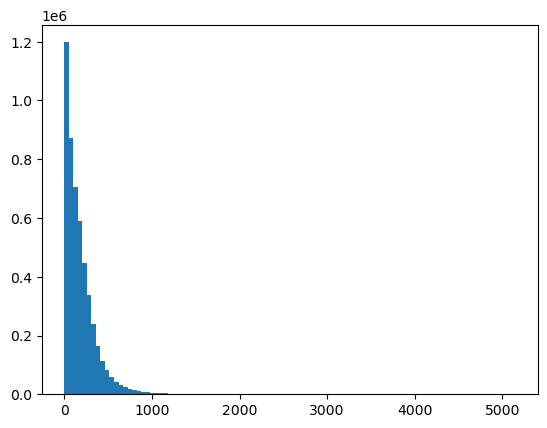

In [10]:
_ = plt.hist( df['higgs_m'][:,0], bins =100)


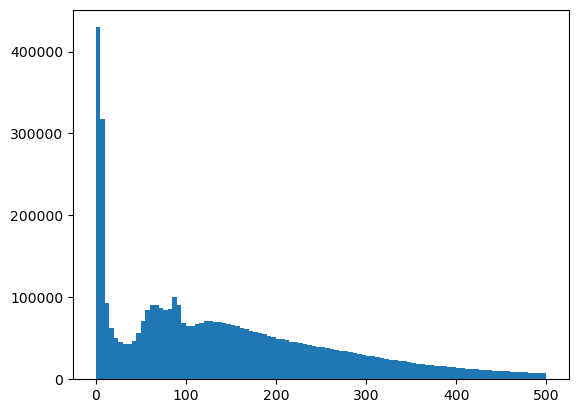

In [11]:
_ = plt.hist( df['higgs_m'][:,0], bins =100, range=(0, 500))



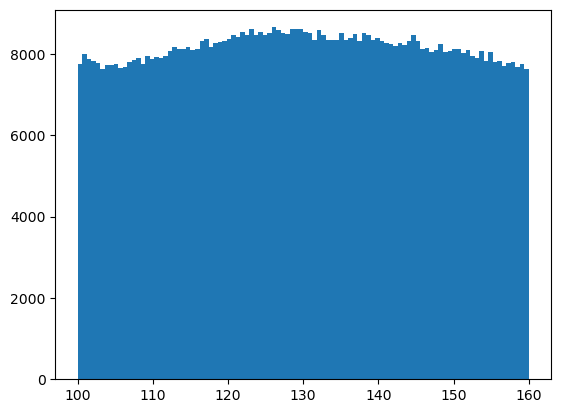

In [12]:
# focus on region of interest
hrange = (100,160)
df = df.query( f"(higgs_m >= {hrange[0]}) & higgs_m <= {hrange[1]}" )
_ = plt.hist( df['higgs_m'][:,0], bins=100, range=hrange )
# Justified from theory/God

In [13]:
def selection(df, query):
    evs_before = df.index.get_level_values('entry').nunique()
    df = df.query( query )
    evs_after = df.index.get_level_values('entry').nunique()
    eff = evs_after / evs_before
    return eff, df

# careful with panda version

In [14]:
# Get all unique entries
entries = df.index.get_level_values('entry').unique()

# Create photon_pt arrays
photon0_pt = np.array([df.loc[(entry, 0), 'photon_pt'] for entry in entries if (entry, 0) in df.index])
photon1_pt = np.array([df.loc[(entry, 1), 'photon_pt'] for entry in entries if (entry, 1) in df.index])

# Create mask for entries that have both photons
common_entries = [entry for entry in entries if (entry, 0) in df.index and (entry, 1) in df.index]
photon0_pt_filtered = np.array([df.loc[(entry, 0), 'photon_pt'] for entry in common_entries])
photon1_pt_filtered = np.array([df.loc[(entry, 1), 'photon_pt'] for entry in common_entries])

# Create the passPT condition
passPT = (photon0_pt_filtered > 50) & (photon1_pt_filtered > 35)

# Create a new column for photon_passPT
df['photon_passPT'] = False

# Apply the mask to both subentries
for i, entry in enumerate(common_entries):
    if passPT[i]:
        df.loc[(entry, slice(None)), 'photon_passPT'] = True

# Call your selection function
eff, df = selection(df, 'photon_passPT')
print('Photon PT efficiency', eff)

# Photon momentum over 35 & 50

/var/folders/50/yzx_7srn6kg7pvy80vjm6qww0000gn/T/ipykernel_2548/3572326144.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['photon_passPT'] = False


Photon PT efficiency 0.27285996446488553


In [15]:
# Get all unique entries
entries = df.index.get_level_values('entry').unique()

# Find entries that have both photon 0 and photon 1
common_entries = [entry for entry in entries if (entry, 0) in df.index and (entry, 1) in df.index]

# Create arrays for photon_isTightID
photon0_isTightID = np.array([df.loc[(entry, 0), 'photon_isTightID'] for entry in common_entries])
photon1_isTightID = np.array([df.loc[(entry, 1), 'photon_isTightID'] for entry in common_entries])

# Create the passID condition
passID = photon0_isTightID & photon1_isTightID

# Create a new column for photon_passID
df['photon_passID'] = False

# Apply the mask to the proper entries
for i, entry in enumerate(common_entries):
    if passID[i]:
        df.loc[(entry, slice(None)), 'photon_passID'] = True

# Call your selection function
eff, df = selection(df, 'photon_passID')
print('Photon ID efficiency', eff)


Photon ID efficiency 0.1654422818882302


In [16]:
# Get all unique entries
entries = df.index.get_level_values('entry').unique()

# Find entries that have both photon 0 and photon 1
common_entries = [entry for entry in entries if (entry, 0) in df.index and (entry, 1) in df.index]

# Get the isTightIso values for both photons
photon0_isTightIso = np.array([df.loc[(entry, 0), 'photon_isTightIso'] for entry in common_entries])
photon1_isTightIso = np.array([df.loc[(entry, 1), 'photon_isTightIso'] for entry in common_entries])

# Create the passIso condition using photon_isTightIso
passIso = photon0_isTightIso & photon1_isTightIso

# Create a new column for passIso
df['passIso'] = False

# Apply the mask to both subentries
for i, entry in enumerate(common_entries):
    if passIso[i]:
        df.loc[(entry, slice(None)), 'passIso'] = True

# Call your selection function
eff, df = selection(df, 'passIso')
print('Photon ISO efficiency', eff)

# %%


Photon ISO efficiency 0.3865078934519612


In [17]:
# First, create the photon_ptom column
df['photon_ptom'] = df['photon_pt'] / df['higgs_m']

# Get all unique entries
entries = df.index.get_level_values('entry').unique()

# Find entries that have both photon 0 and photon 1
common_entries = [entry for entry in entries if (entry, 0) in df.index and (entry, 1) in df.index]

# Get the photon_ptom values for both photons
photon0_ptom = np.array([df.loc[(entry, 0), 'photon_ptom'] for entry in common_entries])
photon1_ptom = np.array([df.loc[(entry, 1), 'photon_ptom'] for entry in common_entries])

# Create the passEnergyRatio condition with the same cut (> 0.35) for both photons
passEnergyRatio = (photon0_ptom > 0.35) & (photon1_ptom > 0.35)

# Create a new column for passEnergyRatio
df['passEnergyRatio'] = False

# Apply the mask to both subentries
for i, entry in enumerate(common_entries):
    if passEnergyRatio[i]:
        df.loc[(entry, slice(None)), 'passEnergyRatio'] = True

# Call your selection function
eff, df = selection(df, 'passEnergyRatio')
print('Energy ratio efficiency', eff)

# %%


Energy ratio efficiency 0.6701522913888694


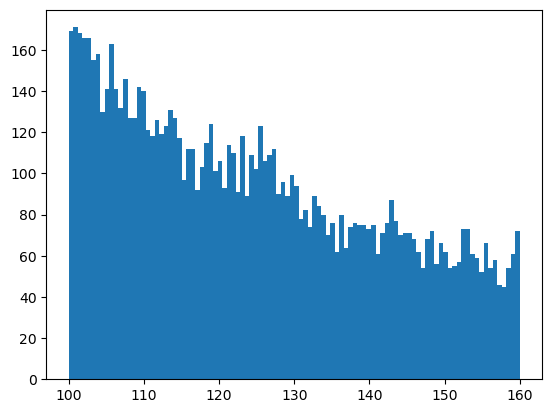

In [18]:
_ = plt.hist( df['higgs_m'][:,0], bins=100, range=hrange )

In [19]:
fpath = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/"

# download MC files
flist = ["mc_343981.ggH125_gamgam.GamGam.root",
         "mc_345041.VBFH125_gamgam.GamGam.root",
         "mc_345318.WpH125J_Wincl_gamgam.GamGam.root",
         "mc_345319.ZH125J_Zincl_gamgam.GamGam.root",
         "mc_341081.ttH125_gamgam.GamGam.root"
        ]

for fname in flist:
    if not os.path.exists( f"../datasets/{fname}" ):
        !mkdir -p ../datasets
        !curl -o ../datasets/{fname} {fpath}/MC/{fname} 
        
# MCMC in MeV

In [20]:
mcdf = ak.to_dataframe(uproot.concatenate("../datasets/mc_*.GamGam.root:mini",
                                          filter_name=['XSection', 
                                                       'mcWeight', 
                                                       'SumWeights',
                                                       'photon_n', 
                                                       'photon_pt', 
                                                       'photon_eta', 
                                                       'photon_phi', 
                                                       'photon_E', 
                                                       'photon_isTightID',
                                                       'photon_ptcone30',
                                                       'photon_etcone20'],
                                          library='ak'))
mcdf



mcWeight  photon_n     photon_pt  photon_eta  photon_phi  \
entry   subentry                                                             
0       0         0.876891         2  94936.632812   -1.529227    0.155986   
        1         0.876891         2  25148.546875    0.351976    1.466846   
1       0         0.876891         2  65155.578125    0.173306    0.030641   
        1         0.876891         2  52137.660156   -0.716728   -2.584272   
2       0         0.876891         2  51062.722656    0.214329    1.233937   
...                    ...       ...           ...         ...         ...   
2473332 1         3.749917         2  51030.183594   -1.566848   -1.962165   
2473333 0         3.749917         2  65130.144531    1.170829   -1.114289   
        1         3.749917         2  63108.429688    0.893904    1.674922   
2473334 0         3.749917         2  60644.906250    0.359489   -0.809405   
        1         3.749917         2  42075.289062    2.363189   -1.927940   

                       photon_E  photon_isTightID  photon_ptcone30  \
entry   subentry                                                     
0       0         229334.250000              True      2375.814941   
        1          26722.484375              True         0.000000   
1       0          66136.500000              True         0.000000   
        1          66112.382812              True         0.000000   
2       0          52240.054688              True         0.000000   
...                         ...               ...              ...   
2473332 1         127581.195312              True         0.000000   
2473333 0         115110.195312              True         0.000000   
        1          90046.625000              True         0.000000   
2473334 0          64605.937500              True         0.000000   
        1         225500.281250              True      2467.598877   

                  photon_etcone20  XSection    SumWeights  
entry   subentry                                           
0       0              219.633514  0.001965  2.138000e+05  
        1              300.454132  0.001965  2.138000e+05  
1       0             -374.782166  0.001965  2.138000e+05  
        1             1027.578735  0.001965  2.138000e+05  
2       0              171.928558  0.001965  2.138000e+05  
...                           ...       ...           ...  
2473332 1             -638.423035  0.008519  3.441426e+06  
2473333 0            -1014.237427  0.008519  3.441426e+06  
        1             -473.188385  0.008519  3.441426e+06  
2473334 0             -679.787903  0.008519  3.441426e+06  
        1              679.221924  0.008519  3.441426e+06  

[4985936 rows x 11 columns]

In [21]:
def selection(df, query):
    evs_before = df.index.get_level_values('entry').nunique()
    df = df.query( query )
    evs_after = df.index.get_level_values('entry').nunique()
    eff = evs_after / evs_before
    return eff, df



In [22]:

mcdf = mcdf.query("photon_n==2")

# make higgs 4-vector
photon1_p4 = vector.arr( { 'pt' : mcdf['photon_pt'][:,0],
                           'eta' : mcdf['photon_eta'][:,0],
                           'phi' : mcdf['photon_phi'][:,0],
                           'E': mcdf['photon_E'][:,0]
                         } )

photon2_p4 = vector.arr( { 'pt' : mcdf['photon_pt'][:,1],
                           'eta' : mcdf['photon_eta'][:,1],
                           'phi' : mcdf['photon_phi'][:,1],
                           'E': mcdf['photon_E'][:,1]
                         } )

higgs_p4 = photon1_p4 + photon2_p4
mcdf.loc[(slice(None), 0), 'higgs_m'] = higgs_p4.m
mcdf.loc[(slice(None), 1), 'higgs_m'] = higgs_p4.m

eff, mcdf = selection(mcdf, "(higgs_m >= 100e3) & (higgs_m <=160e3)")
print(eff)

# %%


/var/folders/50/yzx_7srn6kg7pvy80vjm6qww0000gn/T/ipykernel_2548/2613715509.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcdf.loc[(slice(None), 0), 'higgs_m'] = higgs_p4.m


0.9946443343473186


In [23]:
# pT cuts

passPT = (mcdf['photon_pt'][:,0] > 50000) & (mcdf['photon_pt'][:,1] > 35000)

mcdf.loc[(slice(None), 0), 'photon_passPT'] = passPT.values
mcdf.loc[(slice(None), 1), 'photon_passPT'] = passPT.values

eff, mcdf = selection(mcdf, 'photon_passPT')
print( 'Photon PT efficiency', eff)

Photon PT efficiency 0.8178709015894174


In [24]:
# photon ID cuts

passID = (mcdf['photon_isTightID'][:,0]) & (mcdf['photon_isTightID'][:,1])

mcdf.loc[(slice(None), 0), 'photon_passID'] = passID.values
mcdf.loc[(slice(None), 1), 'photon_passID'] = passID.values

eff, mcdf = selection(mcdf, 'photon_passID')
print( 'Photon ID efficiency', eff)

# %%


passIso = (mcdf['photon_ptcone30'][:,0]/mcdf['photon_pt'][:,0]<0.065) & (mcdf['photon_ptcone30'][:,1]/mcdf['photon_pt'][:,1]<0.065) &(abs(mcdf['photon_etcone20'][:,0])/mcdf['photon_pt'][:,0]<0.065) &(abs(mcdf['photon_etcone20'][:,1])/mcdf['photon_pt'][:,1]<0.065)

mcdf.loc[(slice(None), 0), 'passIso'] = passIso.values
mcdf.loc[(slice(None), 1), 'passIso'] = passIso.values


eff, mcdf = selection(mcdf, 'passIso')
print( 'Photon ISO efficiency', eff)

# %%


Photon ID efficiency 0.8011707923954035
Photon ISO efficiency 0.8646888293682055


In [25]:
# photon energy ratio cuts
mcdf['photon_ptom'] = mcdf['photon_pt'] / mcdf['higgs_m']

passEnergyRatio = (mcdf['photon_ptom'][:,0] > 0.35) & (mcdf['photon_ptom'][:,1] > 0.35)
# Modified as asked
mcdf.loc[(slice(None), 0), 'passEnergyRatio'] = passEnergyRatio.values
mcdf.loc[(slice(None), 1), 'passEnergyRatio'] = passEnergyRatio.values

eff, mcdf = selection(mcdf, 'passEnergyRatio')
print( 'Energy ratio efficiency', eff)



Energy ratio efficiency 0.800833063055512


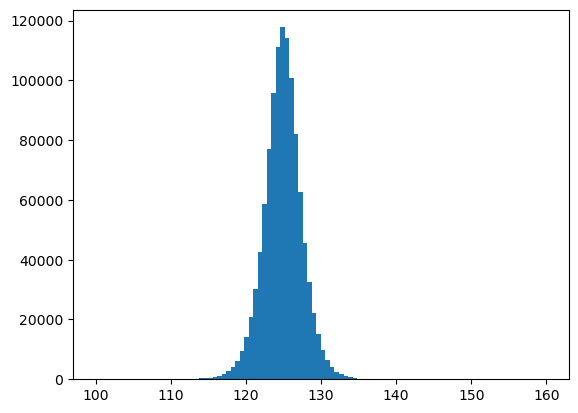

In [26]:
_ = plt.hist( mcdf['higgs_m'][:,0]/1000, bins=100, range=hrange )



In [27]:

lumi = 36.1 # inverse fb in this dataset
# luminosity
mcdf['overallWeight'] = mcdf['mcWeight'] * mcdf['XSection']*1000 * lumi / mcdf['SumWeights']

smSigExp = mcdf['overallWeight'][:,0].sum() / 6
print("Total expected signal events: ", smSigExp)
# Scaling yield by 6

Total expected signal events:  177.4973347981771


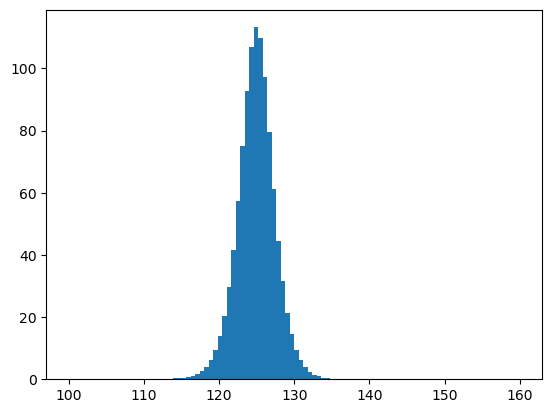

In [28]:
mc_m = mcdf['higgs_m'][:,0].values / 1000
mc_w = mcdf['overallWeight'][:,0].values
_ = plt.hist( mc_m, weights=mc_w, range=hrange, bins=100)


In [29]:
from iminuit import cost, Minuit
from numba_stats import norm, crystalball

def g1CDF(x, mu, sg):
    return norm.cdf(x, mu, sg)

def g2CDF(x, mu, f, sg1, sg2):
    return f * norm.cdf(x, mu, sg1) + (1-f) * norm.cdf(x, mu, sg2)

def g3CDF(x, mu, f1, f2, sg1, sg2, sg3):
    f3 = 1 - f1 - f2
    c1 = f1 * norm.cdf(x, mu, sg1)
    c2 = f2 * norm.cdf(x, mu, sg2)
    c3 = f3 * norm.cdf(x, mu, sg3)
    return c1 + c2 + c3

def cbCDF(x, mu, sg, b, m):
    return crystalball.cdf(x, b, m, mu, sg)

def cbgCDF(x, mu, f, sg1, sg2, b, m):
    return f * norm.cdf(x, mu, sg1) + (1-f) * crystalball.cdf(x, b, m, mu, sg2)
    


In [30]:
# NOTICE this is a weighted fit
import numpy as np
nh, xe = np.histogram( mc_m, weights=mc_w, bins=30, range=(110,140) )
nh2, _ = np.histogram( mc_m, weights=mc_w**2, bins=30, range=(110,140) )

n2ll = cost.BinnedNLL( np.transpose((nh,nh2)), xe, cbgCDF )

mi = Minuit( n2ll, mu=125, f=0.52, sg1=1.8, sg2=3.2, b=3.5, m=3 )

mi.fixed["m"] = True
mi.limits["mu"] = (120,130)
mi.limits["sg1", "sg2"] = [(0,8),(0,10)]
mi.limits["b"] = (0,10)
mi.limits["f"] = (0.01,0.99)
mi.migrad()

# Siganl only

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1431 (χ²/ndof = 57.2)      │             Nfcn = 1120              │
│ EDM = 0.215 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │ 124.94627 │  0.00005  │            │            │   120   │   130   │       │
│ 1 │ f    │539.81916e-3│0.00004e-3 │            │            │  0.01   │  0.99   │       │
│ 2 │ sg1  │ 1.801678  │ 0.000012  │            │            │    0    │    8    │       │
│ 3 │ sg2  │ 3.199765  │ 0.000013  │            │            │    0    │   10    │       │
│ 4 │ b    │ 3.4995303 │ 0.0000009 │            │            │    0    │   10    │       │
│ 5 │ m    │   3.00    │   0.03    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────────────────────────────┐
│     │       mu        f      sg1      sg2        b        m │
├─────┼───────────────────────────────────────────────────────┤
│  mu │ 2.73e-09        0        0        0        0        0 │
│   f │        0 1.53e-15  8.1e-15 -2.2e-15        0        0 │
│ sg1 │        0  8.1e-15 1.38e-10  0.12e-9  0.2e-12        0 │
│ sg2 │        0 -2.2e-15  0.12e-9 1.76e-10  0.3e-12        0 │
│   b │        0        0  0.2e-12  0.3e-12 8.04e-13        0 │
│   m │        0        0        0        0        0        0 │
└─────┴───────────────────────────────────────────────────────┘

In [31]:
sig_pars = mi.values.to_dict()

In [32]:
from numba_stats import bernstein

def polCDF(x, b0, b1, b2, b3, b4):
    beta = [b0, b1, b2, b3, b4]
    bkgd = bernstein.integral(x, beta, hrange[0], hrange[1])
    bkgn = np.diff( bernstein.integral(hrange, beta, hrange[0], hrange[1]) )
    return bkgd / bkgn


def totalCDF(x, b0, b1, b2, b3, b4, Nb, mu):
    bkg = Nb * polCDF(x, b0, b1, b2, b3, b4)
    sig = mu * smSigExp * cbgCDF(x, **sig_pars)
    return bkg+sig




In [33]:
dset = df['higgs_m'][:,0].values.astype(np.float64)
nh, xe = np.histogram(dset, bins=55, range=hrange)
n2ll = cost.ExtendedBinnedNLL(nh, xe, totalCDF)

mi = Minuit(n2ll, b0=1, b1=0.5, b2=0.3, b3=0.2, b4=0.1, Nb=len(dset), mu=0)
mi.limits["b0","b1","b2","b3","b4"] = (0,None)

# Fit the background only first
mi.fixed["mu"] = True
mi.limits["b0","b1","b2","b3","b4"] = (0,1)
mi.migrad()
mi.hesse()
# call a second time to help convergence
mi.migrad()

# save the n2ll at the minimum
bkgo_n2ll = mi.fval

# save the background only fit par values
bkgo_pars = mi.values.to_dict()

# display the fit result
mi

# %%


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 57.44 (χ²/ndof = 1.2)      │              Nfcn = 229              │
│ EDM = 8.28e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b0   │   0.54    │   0.22    │            │            │    0    │    1    │       │
│ 1 │ b1   │   0.27    │   0.12    │            │            │    0    │    1    │       │
│ 2 │ b2   │   0.35    │   0.15    │            │            │    0    │    1    │       │
│ 3 │ b3   │   0.15    │   0.07    │            │            │    0    │    1    │       │
│ 4 │ b4   │   0.19    │   0.08    │            │            │    0    │    1    │       │
│ 5 │ Nb   │  9.55e3   │  0.10e3   │            │            │         │         │       │
│ 6 │ mu   │    0.0    │    0.1    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────────────────────────────┐
│    │       b0       b1       b2       b3       b4       Nb       mu │
├────┼────────────────────────────────────────────────────────────────┤
│ b0 │   0.0508    0.025    0.033    0.014    0.017    -0.00     0.00 │
│ b1 │    0.025   0.0149    0.014    0.008    0.009   -0.000    0.000 │
│ b2 │    0.033    0.014   0.0234    0.007    0.011   -0.000    0.000 │
│ b3 │    0.014    0.008    0.007  0.00517    0.005   -0.000    0.000 │
│ b4 │    0.017    0.009    0.011    0.005  0.00609   -0.000    0.000 │
│ Nb │    -0.00   -0.000   -0.000   -0.000   -0.000 9.52e+03      0e3 │
│ mu │     0.00    0.000    0.000    0.000    0.000      0e3        0 │
└────┴────────────────────────────────────────────────────────────────┘

In [34]:
# then fit the signal + background

# release the fix on signal strength "mu"
mi.fixed["mu"] = False
mi.limits["mu"] = (-5,5)

# run minimisation
# needs a couple of attempts for convergence
mi.migrad()
mi.hesse()
mi.migrad()

# save n2ll at minimum
sb_n2ll = mi.fval

# save best fit parameter values
sb_pars = mi.values.to_dict()
mi



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.77 (χ²/ndof = 0.9)      │              Nfcn = 468              │
│ EDM = 3.71e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b0   │   0.55    │   0.23    │            │            │    0    │    1    │       │
│ 1 │ b1   │   0.27    │   0.12    │            │            │    0    │    1    │       │
│ 2 │ b2   │   0.29    │   0.13    │            │            │    0    │    1    │       │
│ 3 │ b3   │   0.19    │   0.09    │            │            │    0    │    1    │       │
│ 4 │ b4   │   0.18    │   0.08    │            │            │    0    │    1    │       │
│ 5 │ Nb   │  9.37e3   │  0.11e3   │            │            │         │         │       │
│ 6 │ mu   │   0.99    │   0.28    │            │            │   -5    │    5    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────────────────────────────┐
│    │       b0       b1       b2       b3       b4       Nb       mu │
├────┼────────────────────────────────────────────────────────────────┤
│ b0 │   0.0554    0.027    0.029    0.019    0.018    -0.14     0.00 │
│ b1 │    0.027    0.016    0.012    0.011    0.009   -0.080    0.000 │
│ b2 │    0.029    0.012   0.0175    0.008    0.010    0.913   -0.005 │
│ b3 │    0.019    0.011    0.008  0.00826    0.006   -0.613    0.003 │
│ b4 │    0.018    0.009    0.010    0.006  0.00598    0.089   -0.000 │
│ Nb │    -0.14   -0.080    0.913   -0.613    0.089 1.17e+04   -13.14 │
│ mu │     0.00    0.000   -0.005    0.003   -0.000   -13.14   0.0794 │
└────┴────────────────────────────────────────────────────────────────┘

In [35]:
# get log-likelihood ratio
d2ll = bkgo_n2ll - sb_n2ll
signif = d2ll**0.5

print(f'-2\Delta ln L = {d2ll:4.2f}')
print(f'Wilks\' significance = {signif:4.2f}')


# 3.6 with better cut

-2\Delta ln L = 12.67
Wilks' significance = 3.56


Text(0, 0.5, '$-2\\Delta\\ln L$')

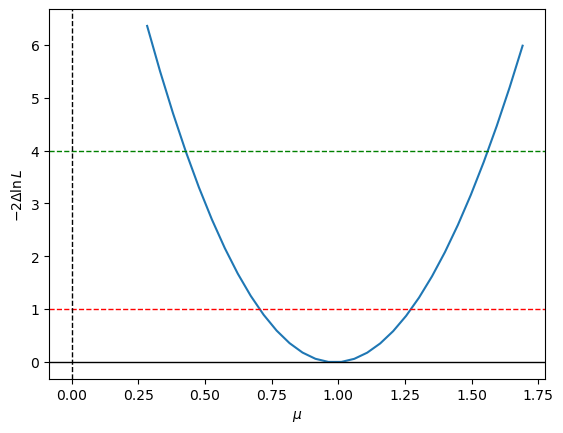

In [36]:
# likelihood scan
x, y, valid = mi.mnprofile("mu", subtract_min=True, bound=2.5)
fig, ax = plt.subplots()
ax.plot(x[valid], y[valid])
ax.axhline(0, c='k', lw=1)
ax.axhline(1, c='r', ls='--', lw=1)
ax.axhline(4, c='g', ls='--', lw=1)
ax.axvline(0, c='k', ls='--', lw=1)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$-2\Delta\ln L$')


In [37]:
def cbgPDF(x, mu, f, sg1, sg2, b, m):
    return f * norm.pdf(x, mu, sg1) + (1-f) * crystalball.pdf(x, b, m, mu, sg2) 

def polPDF(x, b0, b1, b2, b3, b4):
    beta = [b0, b1, b2, b3, b4]
    bkgd = bernstein.density(x, beta, hrange[0], hrange[1])
    bkgn = np.diff( bernstein.integral(hrange, beta, hrange[0], hrange[1]) )
    return bkgd / bkgn

def totalPDF(x, b0, b1, b2, b3, b4, Nb, mu, comps=['b','s']):
    bkg = Nb * polPDF(x, b0, b1, b2, b3, b4)
    sig = mu * smSigExp * cbgPDF(x, **sig_pars)
    res = np.zeros_like(x)
    if 'b' in comps:
        res += bkg
    if 's' in comps:
        res += sig
    return res




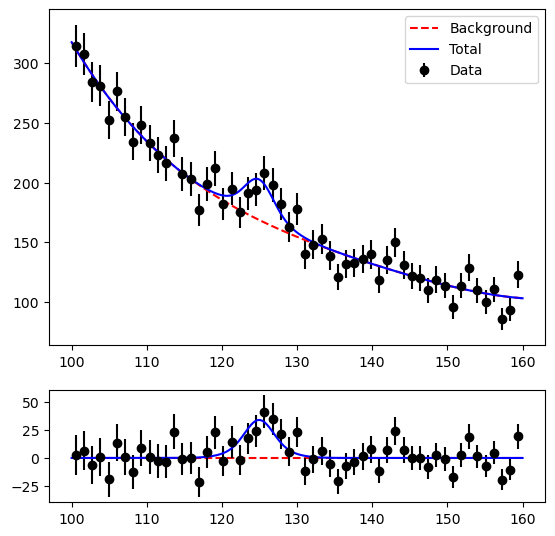

In [38]:
cx = 0.5*(xe[1:]+xe[:-1])
bw = xe[1]-xe[0]

fig, ax = plt.subplots(2, 1, figsize=(6.4,6.4), gridspec_kw={'height_ratios': (3,1)} )

ax[0].errorbar(cx, nh, nh**0.5, fmt='ko', label='Data')

x = np.linspace(*hrange, 400)
yb = bw*totalPDF(x, **sb_pars, comps=['b'])
ys = bw*totalPDF(x, **sb_pars, comps=['s'])
yt = bw*totalPDF(x, **sb_pars)

ax[0].plot(x, yb, 'r--', label='Background')
ax[0].plot(x, yt, 'b-', label='Total')

ax[0].legend()

# resid
cb = bw*totalPDF(cx, **sb_pars, comps=['b'])
dy = nh - cb
ax[1].plot( hrange, [0,0], 'r--' )
ax[1].errorbar( cx, dy, nh**0.5, fmt='ko' )
ax[1].plot( x, yt-yb, 'b-' )